In [60]:
# import statements
import xarray as xr
from wofs.post.wofs_cbook import calc_mslp, calc_var_at_plev
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

In [30]:
# function because some of the simulations have a messed-up calendar
def preprocess(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

def load(var: str, init_time: str, ens_num: int):
    path = "/mnt/drive2/wof-runs/"+init_time+"/"+var+"/wrfwof*.{:02d}".format(ens_num)
    return(xr.open_mfdataset(path,preprocess=preprocess,
                          decode_times=False,combine="nested",
                          concat_dim="Time")
    )
def fix_xtime(ds_in: xr.Dataset,init_time: str) -> xr.Dataset:
    if init_time in ["20", "21", "22", "23"]:
        start_date = "2021-09-01"
    elif init_time in ["00", "01", "02"]:
        start_date = "2021-09-02"
    else:
        raise ValueError("Unexpected init_time provided.")
    ds_in.XTIME.attrs["units"] = "minutes since "+start_date+" "+init_time+":00:00"
    ds_in.XTIME.attrs["description"] = ("minutes since "+start_date+" "+
                                        init_time+":00:00")
    return(xr.decode_cf(ds_in))

In [31]:
path = "/mnt/drive2/wof-runs/21Z/"
z = xr.open_dataarray(path + "z/wrfwof_d01_2021-09-01_21:00:00.01")
P = xr.open_dataarray(path + "P/wrfwof_d01_2021-09-01_21:00:00.01")
PB = xr.open_dataarray(path + "PB/wrfwof_d01_2021-09-01_21:00:00.01")

In [37]:
pres = (P + PB).rename('pres')

In [38]:
ds = xr.merge([z,pres])

In [43]:
grid = Grid(ds, coords={"Z":{"center":"bottom_top"}}, periodic=False)
levels = np.array([85000, 70000, 50000, 30000, 20000])

In [44]:
z_pres = grid.transform(ds.z,"Z",levels,target_data=ds.pres,method="log")

/home/janoski/miniforge3/envs/wofs_post/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [61]:
# get central latitude and longitude for projections
lat = z_pres.XLAT.squeeze()
lon = z_pres.XLONG.squeeze()
central_latitude = float(lat.mean())
central_longitude = float(lon.mean())

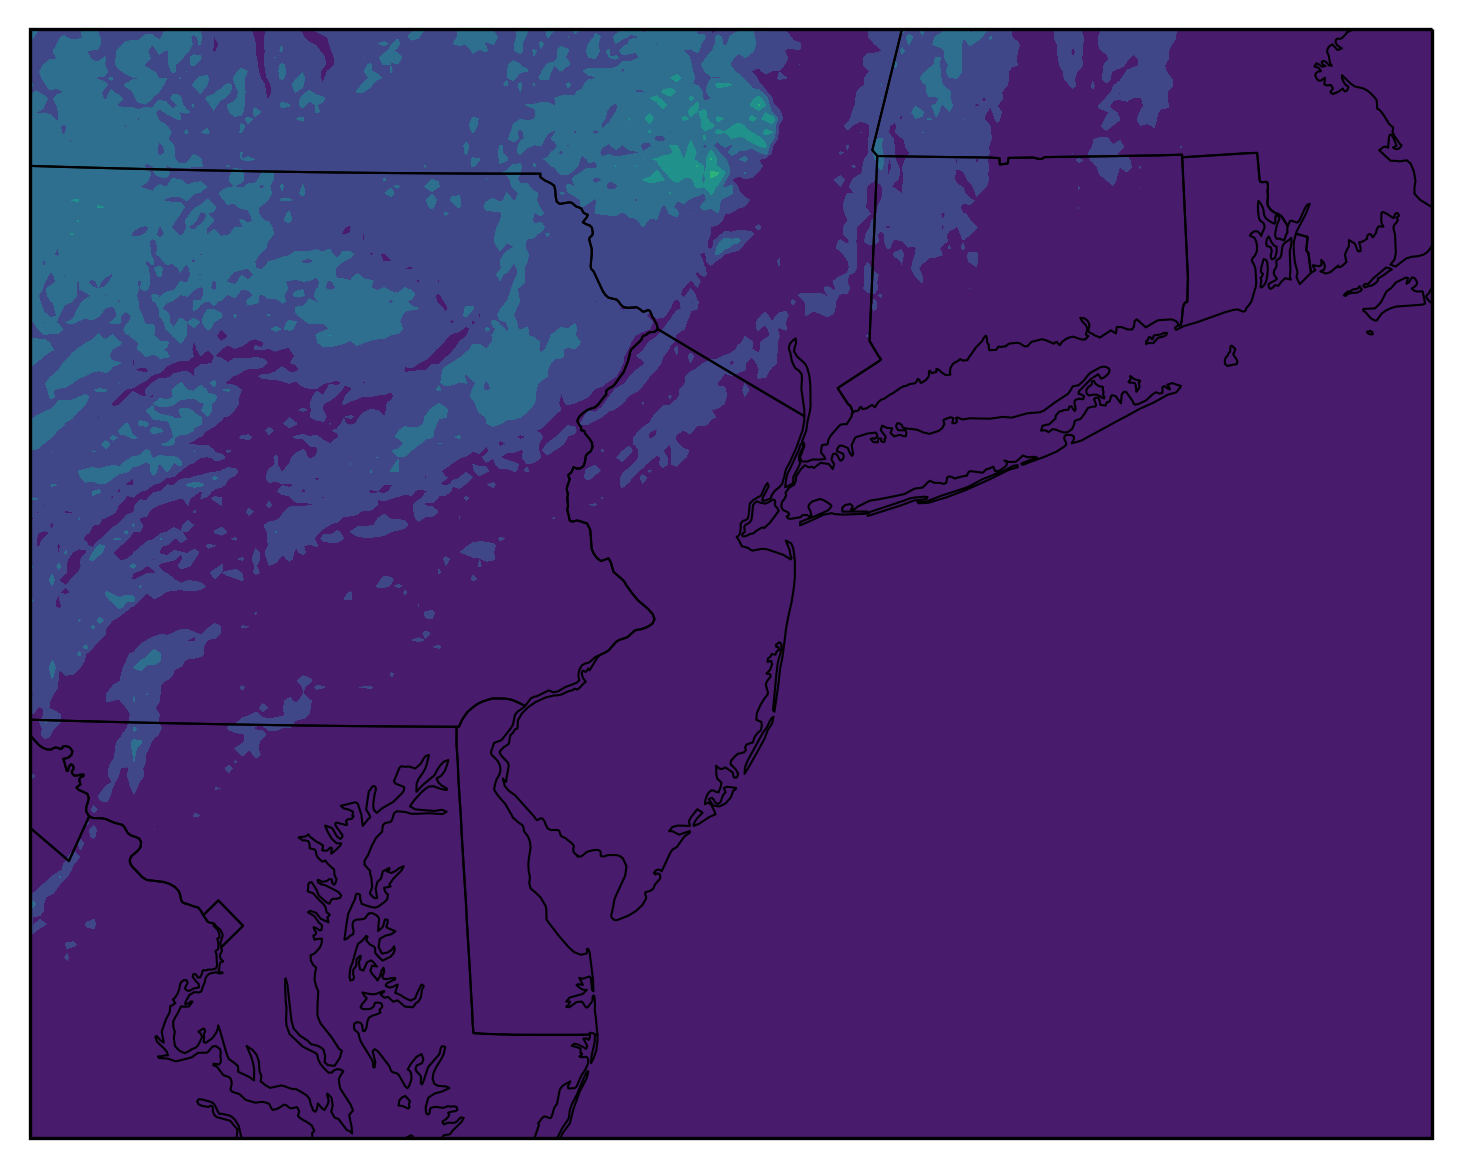

In [78]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),
                         dpi=300)

                         
c = ax.contourf(lon,lat,z.isel(bottom_top=0).squeeze(),
                transform=ccrs.PlateCarree()
)
c.axes.set_extent(region,crs=ccrs.PlateCarree())
c.axes.add_feature(cfeature.STATES,linewidth=linewidth)

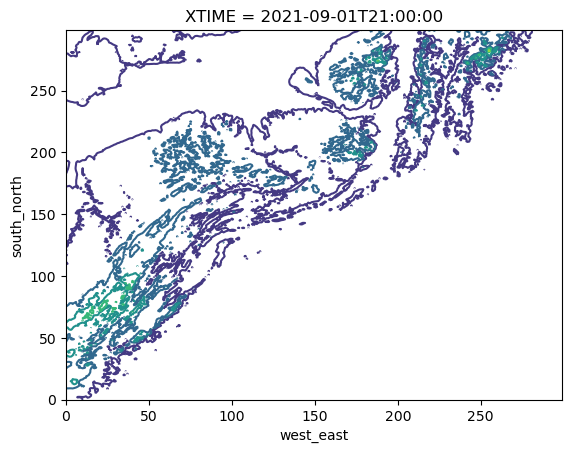

In [69]:
xr.plot.contour(z.isel(bottom_top=0).squeeze())

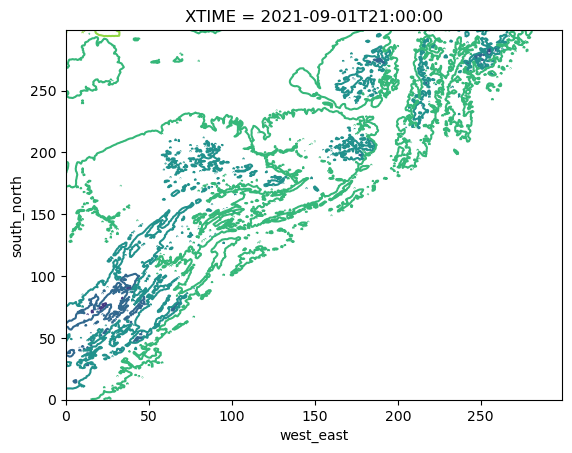

In [74]:
xr.plot.contour(pres.isel(bottom_top=20).squeeze())